## Variational Formulation for Steady State Flow in 3D

Begin with the strong form given by:  
    
$$\nabla\cdot\left[\frac{k}{\mu}(\nabla P + \rho g \hat{z})\right] = 0 $$

Multiplying by test function $v \in H_1(\Omega)$ and integrating across domain $\Omega$ yields:

$$\int_{\Omega}v\nabla\cdot\left[\frac{k}{\mu}(\nabla P + \rho g \hat{z})\right] = 0$$

Integrating by parts yields:

$$-\int_{\Omega}\left<\nabla v,\left[\frac{k}{\mu}(\nabla P + \rho g \hat{z})\right]\right> + \int_{\Gamma_{N}}v\left<\left[\frac{k}{\mu}(\nabla P + \rho g \hat{z})\right], \hat{n}\right> = 0$$

where $\left<\cdot,\cdot\right>$ denotes the inner product on $\Omega$ and $\Gamma_{N}$ represents the neumann boundary.

Rearranging and simplifying the equation above yields:

$$\int_{\Omega}\left<\nabla v,\left[\frac{k}{\mu}(\nabla P + \rho g \hat{z})\right]\right> = \int_{\Gamma_{N}}v\left<\left[\frac{k}{\mu}(\nabla P + \rho g \hat{z})\right], \hat{n}\right> $$

It then follows that by isolating the term of interest ($P$) on the left, we obtain the complete variational form for steady state flow without source/sink terms.

$$\int_{\Omega}\left<\nabla v,\frac{k}{\mu}\nabla P\right> = \int_{\Gamma_{N}}v\left<\frac{k}{\mu}\nabla P, \hat{n}\right>  + \int_{\Gamma_{N}}v\left<\frac{k}{\mu}\rho g \hat{z}, \hat{n}\right> 
- \int_{\Omega}\left<\nabla v,\frac{k}{\mu}\rho g \hat{z}\right> $$

In [1]:
# Import FEniCS
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import math

# Top Boundary: Helper function required by fenics
class Top(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[2],0.0)

# Bottom Boundary: Helper function required by fenics
class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[2],-20.0)

# Left Boundary: Helper function required by fenics
class SideLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0],0.0)

# Right Boundary: Helper function required by fenics
class SideRight(SubDomain): 
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 20.0)

# Front Boundary: Helper function required by fenics
class SideFront(SubDomain): 
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1],0.0)

# Back Boundary: Helper function required by fenics
class SideBack(SubDomain): 
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1],20.0)
    
class FlowElastic3D:
    def __init__(self):
        self.d = 2 # order of the elements, here quadratic piecewise polynomials are used
        self.g = Constant((0.,0.,9.81)) # this represents g*z where z is the upward pointing unit vector
        self.k = 2.46730816679E-13 # 250 mD convert to m^2
        self.mu = 0.0005 # 0.5 cP (Viscosity value for a sodium formate brine w/ rho = 1100 and T = 100 C )
        self.rho = Constant(1100.) # Density of 1100 kg/m^3
        self.generate_mesh() # Generates the mesh
        self.set_boundary_conditions() # Enforces Boundary Conditions
        
    def generate_mesh(self):
        x0 = 0. # Define min(x)
        y0 = 0. # Define min(y)
        x1 = 20. # Define max(x)
        y1 = 20. # Define max(y)
        z1 = 0. # Define max(z)
        z0 = -20. # Define min(z)
        nx = 20 # Number of cells in x-direction
        ny = 20 # Number of cells in y-direction
        nz = 20 # Number of cells in z-direction
        self.mesh = BoxMesh(Point(x0, y0, z0), Point(x1, y1, z1), nx, ny, nz) # creates rectangular mesh
        self.Vh = FunctionSpace(self.mesh, "Lagrange", self.d) # Define function space on mesh (Lagrange with order = self.d)
        # Initialize mesh function for interior domains
        self.domains = MeshFunction('size_t', self.mesh, self.mesh.topology().dim()-1)
        self.domains.set_all(0) # Set all cell markets to 0 (Later changed in set_boundary_conditions)
    
        
    def set_boundary_conditions(self):
        # Instantiate classes that prescribe boundaries
        self.TopDirichlet  = Constant(0.) # Top most boundary condition (Dirichlet)
        self.SideNeumann = Constant(0.) # Boundary condition on sides (Neumann)
        self.BottomNeumann = Constant(9.81*1100.0) # Bottom boundary Condition = rho*g
        self.TopBoundary = Top() # Instantiate classes
        self.BottomBoundary = Bottom() # Instantiate classes
        self.LeftBoundary = SideLeft() # Instantiate classes
        self.RightBoundary = SideRight() # Instantiate classes
        self.FrontBoundary = SideFront() # Instantiate classes
        self.BackBoundary = SideBack() # Instantiate classes
        self.TopBoundary.mark(self.domains, 1) # Mark cells belonging to top boundary with integer = 1
        self.BottomBoundary.mark(self.domains, 2) # Mark cells belonging to bottom boundary with integer = 2
        self.LeftBoundary.mark(self.domains, 3) # Mark cells belonging to left side boundary with integer = 3
        self.RightBoundary.mark(self.domains, 4) # Mark cells belonging to right side boundary with integer = 4
        self.FrontBoundary.mark(self.domains, 5) # Mark cells belonging to front side boundary with integer = 5
        self.LeftBoundary.mark(self.domains, 6) # Mark cells belonging to back side boundary with integer = 6                       
        self.bcs = [DirichletBC(self.Vh, self.TopDirichlet, self.domains, 1)] # Create object to store Dirichlet Boundary Conditions
        self.ds = Measure("ds", subdomain_data=self.domains) # Create a measure to easily identify parts of the domain

    def solve_system(self):
        # Construct function spaces to search for solution
        n = FacetNormal(self.mesh) # Get normal component to mesh
        uh = TrialFunction(self.Vh) # Set up trial function based on function space (Vh)
        vh = TestFunction(self.Vh) # Set up test function based on funtion space(Vh)
        a = inner((self.k/self.mu)*grad(uh), grad(vh))*dx # Define left hand side 
        L = (self.k/self.mu)*self.BottomNeumann*vh*self.ds(2) - inner((self.k/self.mu)*self.g*self.rho, grad(vh))*dx \
        + (self.k/self.mu)*self.rho*dot(self.g,n)*vh*self.ds(2) # Define right hand side
        A, b = assemble_system(a, L, self.bcs) # Assembly
        self.u = Function(self.Vh) # Define place holder function
        solve(A, self.u.vector(), b) # Solve for weights for function u
        # Return the solution
        return self.u
      
        
    def plot_solution(self):
        # Define plot size
        plt.rcParams['figure.figsize'] = [22, 11]
        # Plot Numerical Solution
        s = plot(self.solve_system()/1e6)
        ax = plt.gca()
        ax.set_xlabel('X [M]')
        ax.set_ylabel('Y [M]')
        ax.set_zlabel('Depth [M]')
        #plt.zlabel("Depth [M]")
        plt.title("Approximation of Hydrostatic Fluid Pressure")
        plt.colorbar(s,label='Pressure [MPa]')
        # Show Plots
        plt.show(s)

In [3]:
TestProb = FlowElastic3D()

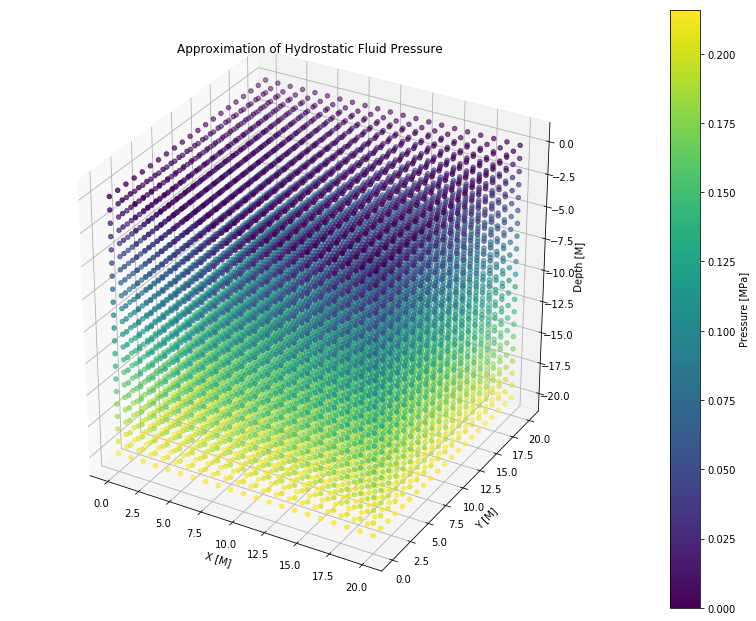

In [4]:
TestProb.plot_solution()

In [5]:
file = File('SteadyState3D.pvd')
file << TestProb.u

In [4]:
TestProb.mesh.num_cells()

48000

### Comparison of Numerical and Analytical Solution (along a vertical transect) 

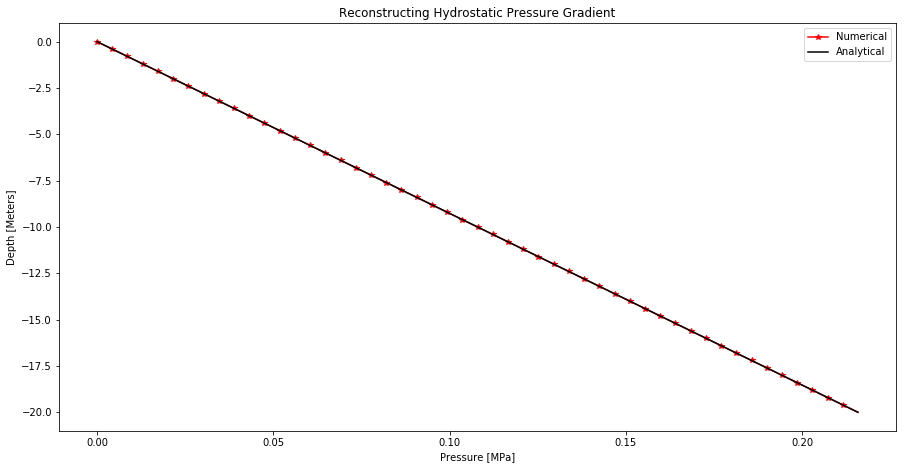

In [5]:
n = 5000
xcoord = 10.0
ycoord = 10.0
zcoord = np.linspace(0.0,-20.0,n) 
VerticalSlice = np.zeros(n)

for i in range(len(zcoord)):
    VerticalSlice[i] = TestProb.u(xcoord,ycoord,zcoord[i])

plt.rcParams['figure.figsize'] = [15, 7.5]
plt.plot(VerticalSlice/1e6,zcoord,color='r',marker='*',markevery=100,label='Numerical')
plt.plot(-zcoord*9.81*1100/1e6,zcoord,'k-',label='Analytical')
plt.title('Reconstructing Hydrostatic Pressure Gradient')
plt.xlabel('Pressure [MPa]')
plt.ylabel('Depth [Meters]')
plt.legend(loc='upper right')
plt.show()